# Billboard Year-End Hot 100: Artist Collaboration Network

This notebook creates a network visualization of Billboard Hot 100 artists' collaboration, from 1999 to 2019 based on [this Kaggle dataset by Daniel DeFoe](https://www.kaggle.com/danield2255/data-on-songs-from-billboard-19992019).


A visualization of 1965-2015 data is [here](https://suzinyou.github.io/posts/chart.html) based on a Kaggle dataset that I can no longer find :(.


* Node size: number of occurrence of the artist
* Node color: number of collaborating artists

Scroll down to see how it was plotted.

## Imports

In [1]:
from itertools import chain, combinations
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, IFrame

import networkx as nx
import plotly.graph_objects as go

In [2]:
sns.set_style('whitegrid')

## Load data

In [3]:
df = pd.read_csv('../data/billboardHot100_1999-2019.csv', index_col=0, parse_dates=['Week', 'Date'])
#df.drop(['Source', 'Song'], axis=1, inplace=True)
df.columns

Index(['Artists', 'Name', 'Weekly.rank', 'Peak.position', 'Weeks.on.chart',
       'Week', 'Date', 'Genre', 'Writing.Credits', 'Lyrics', 'Features'],
      dtype='object')

In [40]:
df.head()

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features,Collaborators,Year,Month,YearHalf
1,"Lil Nas,",Old Town Road,1,1.0,7.0,2019-07-06,2019-04-05,"Country,Atlanta,Alternative Country,Hip-Hop,Tr...","Jozzy, Atticus ross, Trent reznor, Billy ray c...","Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm...",Billy Ray Cyrus,"[Lil Nas, Billy Ray Cyrus]",2019,7,2
2,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,2019-07-06,2019-06-21,Pop,"Cashmere cat, Jack patterson, Charli xcx, Benn...",Senorita \nI love it when you call me senorita...,NaN,"[Shawn Mendes, Camila Cabello]",2019,7,2
3,Billie Eilish,Bad Guy,3,2.0,13.0,2019-07-06,2019-03-29,"Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...","Billie eilish, Finneas","bad guy \nWhite shirt now red, my bloody nose\...",NaN,[Billie Eilish],2019,7,2
4,Khalid,Talk,4,3.0,20.0,2019-07-06,2019-02-07,"Synth-Pop,Pop","Howard lawrence, Guy lawrence, Khalid",Talk \nCan we just talk? Can we just talk?\nTa...,NaN,[Khalid],2019,7,2
5,"Ed Sheeran, Justin Bieber",I Don't Care,5,2.0,7.0,2019-07-06,2019-05-10,"Canada,UK,Dance,Dance-Pop,Pop","Ed sheeran, Justin bieber, Shellback, Max mart...",I Don't Care \nI'm at a party I don't wanna be...,NaN,"[Ed Sheeran, Justin Bieber]",2019,7,2


In [5]:
df.describe()

,Weekly.rank,Peak.position,Weeks.on.chart
count,97225.000000,90156.00000,90156.000000
mean,50.452373,36.58665,12.542948
std,28.816813,27.36506,9.123191
min,1.000000,1.00000,0.000000
25%,26.000000,11.00000,6.000000
50%,50.000000,33.00000,11.000000
75%,75.000000,59.00000,17.000000
max,100.000000,100.00000,87.000000


In [4]:
display(Markdown(f"Data range: {df.Week.min()}~{df.Week.max()}"))

Data range: 1999-07-12 00:00:00~2019-07-06 00:00:00

# Data Cleaning Notes

Issues and remedies.
* There are 253 songs with incorrect release dates, lyrics, and possibly writing credits.
    * We'll have to scrape for the correct information.
* Some artists' names have been parsed wrong. For example, Ne-yo consistently appears as just `Ne`. 
    * We can probably use song names to infer the correct artist names, df[(df.Name=='Let Me Love You') & (df.Artists=='Ne')].head()but this will also require external data.
    

**Example.**  Ne-yo's Let Me Love You has the `Date`, `Genre`, `Writing.Credits`, and `Lyrics` of Ariana Grande's 2016 song of the same title.

In [62]:
filter_lmlu = df.Name=='Let Me Love You'
display(df[filter_lmlu & (df.Artists=='Ne')].head())
display(df[filter_lmlu & (df.Artists=='Ariana Grande')].head())

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features,Collaborators
31524,Ne,Let Me Love You,47,6.0,28.0,2013-02-22,2016-04-18,"Trap,R&;B,Rap,Pop","Ob obrien, Fki 1st, Jeremih, Mr franks, Tbhits...",Let Me Love You \nI just broke up with my ex\n...,NaN,[Ne]
31612,Ne,Let Me Love You,38,6.0,27.0,2013-02-15,2016-04-18,"Trap,R&;B,Rap,Pop","Ob obrien, Fki 1st, Jeremih, Mr franks, Tbhits...",Let Me Love You \nI just broke up with my ex\n...,NaN,[Ne]
31706,Ne,Let Me Love You,35,6.0,26.0,2013-02-08,2016-04-18,"Trap,R&;B,Rap,Pop","Ob obrien, Fki 1st, Jeremih, Mr franks, Tbhits...",Let Me Love You \nI just broke up with my ex\n...,NaN,[Ne]
31800,Ne,Let Me Love You,33,6.0,25.0,2013-02-01,2016-04-18,"Trap,R&;B,Rap,Pop","Ob obrien, Fki 1st, Jeremih, Mr franks, Tbhits...",Let Me Love You \nI just broke up with my ex\n...,NaN,[Ne]
31887,Ne,Let Me Love You,24,6.0,24.0,2013-01-25,2016-04-18,"Trap,R&;B,Rap,Pop","Ob obrien, Fki 1st, Jeremih, Mr franks, Tbhits...",Let Me Love You \nI just broke up with my ex\n...,NaN,[Ne]


,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features,Collaborators
16021,Ariana Grande,Let Me Love You,99,NaN,NaN,2016-05-07,2016-04-18,"Trap,R&;B,Rap,Pop","Ob obrien, Fki 1st, Jeremih, Mr franks, Tbhits...",Let Me Love You \nI just broke up with my ex\n...,Lil Wayne,"[Ariana Grande, Lil Wayne]"


All songs with incorrect release dates (and other info)

In [64]:
firsts = df.groupby(['Name', 'Artists']).first().reset_index()
firsts[firsts.Week < firsts.Date]

,Name,Artists,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features,Collaborators
64,5 Star,Yo Gotti,84,79.0,2.0,2009-12-03,2012-01-10,"Remix,Rap","Yo gotti, Gucci mane, Nicki minaj, Trina","5 Star Remix \nChea! Yeah\nAy, you know I'm lo...",None,[Yo Gotti]
81,8th Of November,"Big, Rich",94,94.0,2.0,2006-07-26,2014-01-01,Country,None,8th of November \nSaid goodbye to his momma as...,None,"[Big, Rich]"
98,A House Is Not A Home,Glee Cast,70,NaN,NaN,2010-05-13,2010-05-18,"TV,Soundtrack,Screen,Cover,Mashup,Pop","Hal david, Burt bacharach",A House Is Not a Home \nOne less bell to answe...,None,[Glee Cast]
101,A Light That Never Comes,"Linkin Park, Steve Aoki",65,NaN,NaN,2013-10-04,2013-10-27,"Rock,Electronic Rock,Pop,Electro House,Electro...","Steve aoki, Linkin park","A Light That Never Comes \nNah, you don't know...",None,"[Linkin Park, Steve Aoki]"
109,A Little Too Much,Shawn Mendes,94,NaN,NaN,2015-02-20,2015-04-14,Pop,Shawn mendes,A Little Too Much \nShe would not show that sh...,None,[Shawn Mendes]
...,...,...,...,...,...,...,...,...,...,...,...,...
6831,When The Stars Go Blue,Tim McGraw,97,37.0,20.0,2006-08-23,2014-01-01,Country,Ryan adams,When the Stars Go Blue \nDancing when the star...,None,[Tim McGraw]
6947,Wild Life,"Jack, Jack",87,NaN,NaN,2014-08-22,2014-10-31,Rap,"Jack gilinsky, Jordan palmer, Rami jrade, Jack...","Wild Life \nWild like\nWild life\nYeah, no\nte...",None,"[Jack, Jack]"
6951,Wild West Show,"Big, Rich",88,85.0,9.0,2004-04-21,2014-01-01,Country,None,Wild West Show \nI'm feeling like Tonto\nRidin...,None,"[Big, Rich]"
7077,Yo,Chris Brown,41,7.0,21.0,2006-05-17,2015-02-20,"R&;B,Rap","Rivelino raoul wouter, Melvin hough ii, Wale, ...","Yo Shit \nThis my shit\nIt's your shit, yeah\n...",None,[Chris Brown]


In [ ]:
clean_dict = {'Ne': 'Ne-Yo', 'Usher And Alicia Keys': 'Usher, Alicia Keys'}

# Artists and Songs

Generate the `Collaborators` column, where each element is a list of collaborators. This includes anyone in the `Aritsts` and `Feature` columns.

In [5]:
comma = re.compile(r'\s*,\s*')

def split_artists(row):
    artists = comma.split(row.Artists)
    if isinstance(row.Features, str):
        artists += comma.split(row.Features)
    return [a for a in artists if a != '']

In [6]:
df['Collaborators'] = df.apply(split_artists, axis=1)

In [5]:
# df.to_pickle('../data/data_collab.pkl')

In [7]:
def get_uniques(_df, display_count=True):
    songs = _df.sort_values('Weeks.on.chart', ascending=False).sort_values('Weekly.rank').groupby(['Artists', 'Name']).first().reset_index()
    artists = set(list(chain(*_df.Collaborators.tolist())))

    if display_count:
        display(Markdown(
            f"* \# unique songs: {len(songs):,d}\n* \# unique artists: {len(artists):,d}"))
        
    return songs, artists

In [8]:
songs, artists = get_uniques(df)

* \# unique songs: 7,213
* \# unique artists: 2,213

## # of Weeks on Chart Rank

In [9]:
df['Year'] = df.Week.dt.year
df['Month'] = df.Week.dt.month

In [11]:
df[['Artists', 'Name', 'Weeks.on.chart']].groupby(['Artists', 'Name']).max().reset_index().sort_values(by='Weeks.on.chart', ascending=False).head(10).reset_index(drop=True)

,Artists,Name,Weeks.on.chart
0,Imagine Dragons,Radioactive,87.0
1,AWOLNATION,Sail,79.0
2,Jason Mraz,I'm Yours,76.0
3,OneRepublic,Counting Stars,68.0
4,Adele,Rolling In The Deep,65.0
5,Carrie Underwood,Before He Cheats,64.0
6,The Lumineers,Ho Hey,62.0
7,Lifehouse,You And Me,62.0
8,Imagine Dragons,Demons,61.0
9,Lady Antebellum,Need You Now,60.0


Logest charting songs per year

In [15]:
df[
    ['Year', 'Artists', 'Name', 'Weeks.on.chart']
].groupby(
    ['Year', 'Artists', 'Name']
).max(
).reset_index(
).sort_values(
    by='Weeks.on.chart', ascending=False
).groupby(
    ['Year']
).first(
).reset_index()

,Year,Artists,Name,Weeks.on.chart
0,1999,Sarah McLachlan,I Will Remember You,40.0
1,2000,Santana,Smooth,58.0
2,2001,Faith Hill,The Way You Love Me,56.0
3,2002,Lifehouse,Hanging By A Moment,53.0
4,2003,3 Doors Down,When I'm Gone,45.0
5,2004,matchbox twenty,Unwell,54.0
6,2005,Kelly Clarkson,Since U Been Gone,46.0
7,2006,Lifehouse,You And Me,62.0
8,2007,Carrie Underwood,Before He Cheats,64.0
9,2008,Finger Eleven,Paralyzer,50.0


# Popular song *titles*!

20년동안의 인기곡 중 중복의 타이틀을 가진 곡들도 많았다.

In [47]:
unique_song_titles = songs.Name.value_counts().to_frame().reset_index().rename(columns={'index': 'Name' ,'Name': 'Count'})

In [48]:
unique_song_titles.head(10)

,Name,Count
0,Home,10
1,Hallelujah,8
2,Breathe,7
3,Beautiful,7
4,Let It Go,6
5,Stay,6
6,X,6
7,Smile,6
8,Without You,5
9,Let Me Love You,5


In [209]:
title = 'Let Me Love You'
df.loc[df.Name == title, ['Artists', 'Name', 'Date', 'Genre', 'Lyrics']].drop_duplicates()

,Artists,Name,Date,Genre,Lyrics
11504,DJ Snake,Let Me Love You,2016-08-04,"Electro-Pop,Tropical House,Canada,Electronic,Pop",Let Me Love You \nI used to believe\nWe were b...
16021,Ariana Grande,Let Me Love You,2016-04-18,"Trap,R&;B,Rap,Pop",Let Me Love You \nI just broke up with my ex\n...
31524,Ne,Let Me Love You,2016-04-18,"Trap,R&;B,Rap,Pop",Let Me Love You \nI just broke up with my ex\n...
31665,Glee Cast,Let Me Love You,2012-02-14,Pop,Let Me Love You \nArtie with New Directions Bo...
68689,Mario,Let Me Love You,2004-11-16,"Pop,R&;B",Let Me Love You \nMmmm\nMmmmm\nYeah\nMmmmm\nYe...


That's a lot of popular songs named 'Home'!

In [79]:
title = 'Hallelujah'
df.loc[df.Name == title, ['Artists', 'Name', 'Date', 'Genre', 'Lyrics']].drop_duplicates()

,Artists,Name,Date,Genre,Lyrics
12613,Pentatonix,Hallelujah,2016-10-21,"A Cappella,Christmas,Pop",Hallelujah \nI've heard there was a secret cho...
13243,Leonard Cohen,Hallelujah,NaT,"Eighties,Adult Alternative,Indie Pop,Alternati...",Hallelujah \nNow I've heard there was a secret...
17658,Lindsey Stirling,Hallelujah,2015-12-07,Pop,Hallelujah \n
17923,Jordan Smith,Hallelujah,NaT,R&;B,Hallelujah \nWell I've heard there was a secre...
20852,Panic! At The Disco,Hallelujah,2015-04-20,"Alternative Pop,Alternative,Alternative Rock,P...",Hallelujah \nOhh!\nA moment you'll never remem...
46061,k.d. lang,Hallelujah,2004-07-27,Pop,Hallelujah \nI heard there was a secret chord\...
46276,"Justin Timberlake, Matt Morris",Hallelujah,NaT,Pop,Hallelujah \nWell I heard there was a secret c...
54709,Kate Voegele,Hallelujah,NaT,Pop,Hallelujah \nWell I've heard there was a sacre...


All of them are Leonard Cohen's songs, except for Panic! At The Disco's.

In [14]:
songs['NumCollaborators'] = songs.Collaborators.apply(len)

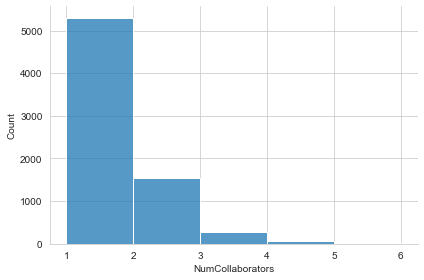

In [19]:
g = sns.displot(songs, x='NumCollaborators', bins=np.arange(1, 7, dtype=int), height=4, aspect=1.5)

# Collaboration Graph

Register nodes to our graph.

In [10]:
class GraphWrapper(object):
    def __init__(self, _df):
        songs = _df.sort_values('Weeks.on.chart', ascending=False).sort_values('Weekly.rank').groupby(['Artists', 'Name']).first().reset_index()
        artists = set(list(chain(*_df.Collaborators.tolist())))
        songs['NumCollaborators'] = songs.Collaborators.apply(len)
        
        # artist maps
        artist2ind = {a: i for i, a in enumerate(sorted(artists))}

        G = nx.Graph()
        counter = 0
        for collaborators in songs.Collaborators:
            for artist in collaborators:
                ind = artist2ind[artist]
                if ind not in G.nodes:
                    G.add_node(ind, artist=artist, count=1)
                else:
                    #if 'artist' not in G.nodes[ind]:
                    #    G.nodes[ind]['artist'] = y
                    G.nodes[ind]['count'] += 1
            
            # add edges between each pair(2) of artists in the collaborators list of this song
            artist_indices = [artist2ind[artist] for artist in collaborators]
            G.add_edges_from(combinations(artist_indices, 2))
            # TODO: add weights

        self.songs = songs
        self.artists = artists
        self.artist2ind = artist2ind
        self.ind2artist = sorted(artists)
        self.graph = G
        self._connected_components = None
        self._cliques = None
            
    @property
    def connected_components(self):
        if self._connected_components is None:
            self._connected_components = list(nx.connected_components(self.graph))
        return self._connected_components
    
    @property
    def ccs(self):
        return self.connected_components
    
    @property
    def cliques(self):
        if self._cliques is None:
            self._cliques = list(nx.enumerate_all_cliques(self.graph))
        return self._cliques

In [11]:
def generate_graph_properties_dict(G):
    clique_lens = np.asarray(list(map(len, G.cliques)))
    top3_clique_id = np.argsort(clique_lens)[::-1][:3]
    top3_cliques = [str([G.ind2artist[i] for i in G.cliques[c]]) for c in top3_clique_id]
    return dict(
        num_songs=G.songs.shape[0],
        num_artists=G.graph.number_of_nodes(), 
        num_edges=G.graph.number_of_edges(), 
        num_connected_components=len(G.ccs), 
        size_largest_component=max(map(len, G.ccs)), 
        num_cliques_le3=np.sum(clique_lens > 3).astype(int),
        size_largest_clique=max(clique_lens),
        largest_cliques=top3_cliques
    )

In [12]:
def display_graph_properties(G):
    clique_lens = np.asarray(list(map(len, G.cliques)))
    top3_clique_id = np.argsort(clique_lens)[::-1][:3]
    top3_cliques = [str([G.ind2artist[i] for i in G.cliques[c]]) for c in top3_clique_id]
    top3_cliques_str = '\n'.join(top3_cliques)
    number_of = '\#'
    linebk = '\n'
    display(Markdown("""* \# unique songs: {:,d} (= # nodes)
* \# unique artists: {:,d} (= # nodes)
* \# relationships: {:,d} (= # edges)
* \# connected components: {:,d}
  * Size of largest component: {:,d} artists
* \# cliques larger than 3: {:,d} cliques
  * Largest clique size: {} artists
  * Largest cliques: 
<code>{}</code>`""".format(
        G.songs.shape[0],
        G.graph.number_of_nodes(), 
        G.graph.number_of_edges(), 
        len(G.ccs), 
        max(map(len, G.ccs)), 
        np.sum(clique_lens > 3).astype(int),
        max(clique_lens),
        top3_cliques_str
    )))

    _ = sns.displot(G.songs, x='NumCollaborators', bins=np.arange(1, 7, dtype=int), height=3, aspect=1.5)

In [73]:
def make_graph(_df, display_info=False, return_dicts=True):
    songs, artists = get_uniques(_df, display_count=display_info)
    songs['NumCollaborators'] = songs.Collaborators.apply(len)
    
    # artist maps
    artist2ind = {a: i for i, a in enumerate(sorted(artists))}
    ind2artist = sorted(artists)

    G = nx.Graph()
    counter = 0
    for l in songs.Collaborators:
        for y in l:
            ind = artist2ind[y]
            if ind not in G.nodes:
                G.add_node(ind, artist=y, count=1)
            else:
                #if 'artist' not in G.nodes[ind]:
                #    G.nodes[ind]['artist'] = y
                G.nodes[ind]['count'] += 1

        G.add_edges_from(combinations([artist2ind[y] for y in l], 2))
    if display_info:
        ccs = list(nx.connected_components(G))
        display(Markdown(f"""* no. unique artists: {G.number_of_nodes():,d} (= # nodes)
            * no. relationships: {G.number_of_edges():,d} (= # edges)
            * no. connected components: {len(ccs):,d}
              * Size of largest component: {max(ccs):,d}
            * no. cliques larger than 3: """))
        _ = sns.displot(songs, x='NumCollaborators', bins=np.arange(1, 7, dtype=int), height=3, aspect=1.5)
    return G, artist2ind, ind2artist

## Yearly

In [13]:
from collections import defaultdict

In [34]:
df['YearHalf'] = df.Month.apply(lambda x: 1 if x < 7 else 2)

In [35]:
yearly_network = dict()
yearly_rows = list()
years = []
for year, _df in df.groupby(['Year', 'YearHalf']):
    _G = GraphWrapper(_df)
    properties = generate_graph_properties_dict(_G)
    yearly_network[year] = _G
    yearly_rows.append(properties)
    years.append(year)

In [36]:
yearly_df = pd.DataFrame(yearly_rows, index=years)

In [23]:
df.Week.min(), df.Week.max()

(Timestamp('1999-07-12 00:00:00'), Timestamp('2019-07-06 00:00:00'))

<AxesSubplot:>

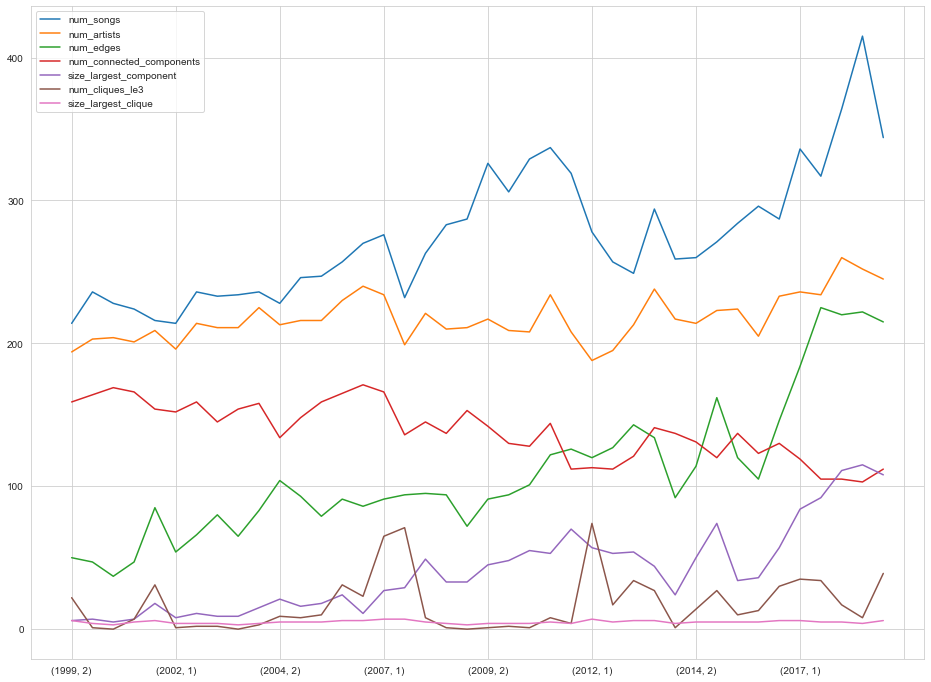

In [39]:
yearly_df[yearly_df.index != (2019, 2)].plot(figsize=(16, 12))

## 1999~2004

* \# unique songs: 1,599 (= # nodes)
* \# unique artists: 814 (= # nodes)
* \# relationships: 431 (= # edges)
* \# connected components: 511
  * Size of largest component: 209 artists
* \# cliques larger than 3: 66 cliques
  * Largest clique size: 6 artists
  * Largest cliques: 
<code>["Lil' Troy", 'Yungsta', 'Fat Pat', "Lil' Will", 'Hawk', 'Big T']
['Ludacris', 'Lil Jon', 'The East Side Boyz', 'Too Short', 'Big Kap', 'Chyna']
['Daddy Yankee', 'N.O.R.E.', 'Nina Sky', 'Gem Star', 'Big Mato']</code>`

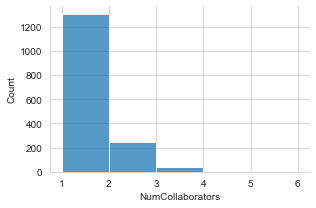

In [142]:
G1 = GraphWrapper(df[(df.Week <= pd.Timestamp(2004,12,31))])

display_graph_properties(G1)

* \# unique songs: 1,599
* \# unique artists: 814

* 814 nodes, 431 edges

* \# of connected components: **511**

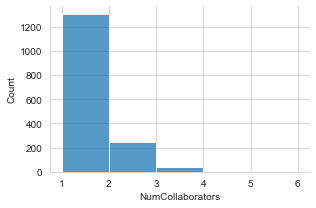

In [24]:
G_9904, artist2ind, ind2artist = make_graph(df[(df.Week <= pd.Timestamp(2004,12,31))], display_info=True)

In [149]:
biggest_cliques = np.argsort(list(map(len, G_9904_cliques)))[::-1][:10]
for c in biggest_cliques:
    print(list(map(lambda x: ind2artist[x], G_9904_cliques[c])))

['Dixie Chicks', 'Kardinal Offishall', 'Carrie Underwood', 'Dolly Parton', 'Chris Classic', 'Andy Griggs']
['Dustin Lynch', 'Digital Farm', 'Jeremih', 'John Legend', 'Andrea Bocelli', 'Belly']
['Bo Bice', 'Finger Eleven', 'Foxes', 'Charlie Wilson', 'Andrew McMahon In The Wilderness']
['Flo Rida', 'India.Arie', 'Empire Of The Sun', 'Avenged Sevenfold', 'Jay Rock']
['Dustin Lynch', 'Digital Farm', 'Jeremih', 'John Legend', 'Andrea Bocelli']
['Dustin Lynch', 'Digital Farm', 'Jeremih', 'Andrea Bocelli', 'Belly']
['Dustin Lynch', 'Digital Farm', 'John Legend', 'Andrea Bocelli', 'Belly']
['Dustin Lynch', 'Jeremih', 'John Legend', 'Andrea Bocelli', 'Belly']
['Dustin Lynch', 'Digital Farm', 'Jeremih', 'John Legend', 'Belly']
['Digital Farm', 'Jeremih', 'John Legend', 'Andrea Bocelli', 'Belly']


In [153]:
cc9904 = list(map(len, nx.connected_components(G_9904)))
cc_counts = pd.Series(cc9904).value_counts().rename('Count').to_frame()
cc_counts.index = cc_counts.index.rename('Connected Component Size')
display(cc_counts)

,Count
Connected Component Size,
1,446
2,48
3,9
4,3
6,2
5,1
7,1
209,1


## 2005~2009

* \# unique songs: 1,828 (= # nodes)
* \# unique artists: 781 (= # nodes)
* \# relationships: 540 (= # edges)
* \# connected components: 461
  * Size of largest component: 238 artists
* \# cliques larger than 3: 144 cliques
  * Largest clique size: 7 artists
  * Largest cliques: 
<code>['Akon', 'DJ Khaled', 'Fat Joe', 'Rick Ross', 'T.I.', "Lil' Wayne", 'Baby']
['Akon', 'DJ Khaled', 'Fat Joe', 'Rick Ross', "Lil' Wayne", 'Baby']
['DJ Khaled', 'Fat Joe', 'Rick Ross', 'T.I.', "Lil' Wayne", 'Baby']</code>`

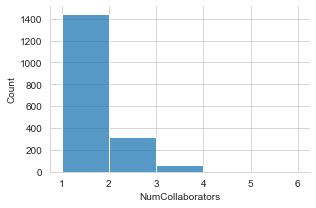

In [143]:
G2 = GraphWrapper(df[(df.Week > pd.Timestamp(2004,12,31)) & (df.Week <= pd.Timestamp(2009,12,31))])

display_graph_properties(G2)

In [156]:
G_0509, artist2ind, ind2artist = make_graph(df[(df.Week > pd.Timestamp(2004,12,31)) & (df.Week <= pd.Timestamp(2009,12,31))], display_info=True)

* \# unique songs: 1,828
* \# unique artists: 781

* 781 nodes, 540 edges

* \# of connected components: **461**

In [157]:
G_0509_cliques = list(nx.enumerate_all_cliques(G_0509))

In [158]:
biggest_cliques = np.argsort(list(map(len, G_0509_cliques)))[::-1][:10]
for c in biggest_cliques:
    print(list(map(lambda x: ind2artist[x], G_0509_cliques[c])))

['Akon', 'DJ Khaled', 'Fat Joe', 'Rick Ross', 'T.I.', "Lil' Wayne", 'Baby']
['Akon', 'DJ Khaled', 'Fat Joe', 'Rick Ross', "Lil' Wayne", 'Baby']
['DJ Khaled', 'Fat Joe', 'Rick Ross', 'T.I.', "Lil' Wayne", 'Baby']
['Akon', 'Lil Wayne', 'DJ Khaled', 'Fat Joe', 'Rick Ross', 'T.I.']
['Akon', 'DJ Khaled', 'Fat Joe', 'Rick Ross', 'T.I.', "Lil' Wayne"]
['Akon', 'DJ Khaled', 'Fat Joe', 'Rick Ross', 'T.I.', 'Baby']
['Akon', 'Lil Wayne', 'DJ Khaled', 'Fat Joe', 'Rick Ross', 'Pitbull']
['Akon', 'DJ Khaled', 'Fat Joe', 'T.I.', "Lil' Wayne", 'Baby']
['Akon', 'DJ Khaled', 'Rick Ross', 'T.I.', "Lil' Wayne", 'Baby']
['Akon', 'Fat Joe', 'Rick Ross', 'T.I.', "Lil' Wayne", 'Baby']


In [159]:
cc0509 = list(map(len, nx.connected_components(G_0509)))
cc_counts = pd.Series(cc0509).value_counts().rename('Count').to_frame()
cc_counts.index = cc_counts.index.rename('Connected Component Size')
display(cc_counts)

,Count
Connected Component Size,
1,402
2,41
3,10
4,6
5,1
238,1


In [50]:
list(map(lambda x: ind2artist[x], connected_comps[3]))

["Lil' Will", 'Yungsta', 'Big T', 'Hawk', "Lil' Troy", 'Fat Pat']

## 2010~2014

* \# unique songs: 1,994 (= # nodes)
* \# unique artists: 748 (= # nodes)
* \# relationships: 704 (= # edges)
* \# connected components: 361
  * Size of largest component: 304 artists
* \# cliques larger than 3: 407 cliques
  * Largest clique size: 7 artists
  * Largest cliques: 
<code>['Lil Wayne', 'Rick Ross', 'T.I.', 'Birdman', 'Meek Mill', 'DJ Khaled', 'Swizz']
['Drake', 'Lil Wayne', 'Future', 'Rick Ross', 'Nicki Minaj', 'Birdman', 'DJ Khaled']
['Drake', 'Lil Wayne', 'Chris Brown', 'Future', 'Rick Ross', 'Nicki Minaj', 'DJ Khaled']</code>`

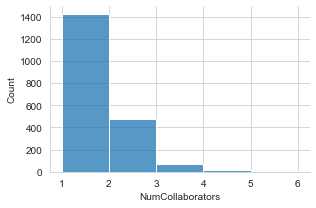

In [145]:
G3 = GraphWrapper(df[(df.Week > pd.Timestamp(2009,12,31)) & (df.Week <= pd.Timestamp(2014,12,31))])

display_graph_properties(G3)

In [176]:
G_1014, artist2ind, ind2artist = make_graph(df[(df.Week > pd.Timestamp(2009,12,31)) & (df.Week <= pd.Timestamp(2014,12,31))], display_info=True)

* \# unique songs: 1,994
* \# unique artists: 749

* 748 nodes, 704 edges

* \# of connected components: **361**

In [177]:
G_1014_cliques = list(nx.enumerate_all_cliques(G_1014))
biggest_cliques = np.argsort(list(map(len, G_1014_cliques)))[::-1][:10]
for c in biggest_cliques:
    print(list(map(lambda x: ind2artist[x], G_1014_cliques[c])))

['Lil Wayne', 'Rick Ross', 'T.I.', 'Birdman', 'Meek Mill', 'DJ Khaled', 'Swizz']
['Drake', 'Lil Wayne', 'Future', 'Rick Ross', 'Nicki Minaj', 'Birdman', 'DJ Khaled']
['Drake', 'Lil Wayne', 'Chris Brown', 'Future', 'Rick Ross', 'Nicki Minaj', 'DJ Khaled']
['Drake', 'Lil Wayne', 'Rick Ross', 'T.I.', 'Birdman', 'Meek Mill', 'DJ Khaled']
['Drake', 'Lil Wayne', 'Chris Brown', 'Rick Ross', 'T.I.', 'DJ Khaled']
['Drake', 'Lil Wayne', 'Rick Ross', 'T.I.', 'Birdman', 'Meek Mill']
['Drake', 'Lil Wayne', 'Rick Ross', 'Nicki Minaj', 'Birdman', 'DJ Khaled']
['Drake', 'Lil Wayne', 'Future', 'Nicki Minaj', 'Birdman', 'DJ Khaled']
['Drake', 'Lil Wayne', 'Future', 'Rick Ross', 'Birdman', 'DJ Khaled']
['Drake', 'Lil Wayne', 'Future', 'Rick Ross', 'Nicki Minaj', 'DJ Khaled']


In [217]:
(a > 3).sum()

407

In [178]:
cc1014 = list(map(len, nx.connected_components(G_1014)))
cc_counts = pd.Series(cc1014).value_counts().rename('Count').to_frame()
cc_counts.index = cc_counts.index.rename('Connected Component Size')
display(cc_counts)

,Count
Connected Component Size,
1,297
2,49
3,10
4,2
5,1
6,1
304,1


## 2015~2019

* \# unique songs: 1,749 (= # nodes)
* \# unique artists: 650 (= # nodes)
* \# relationships: 911 (= # edges)
* \# connected components: 233
  * Size of largest component: 364 artists
* \# cliques larger than 3: 493 cliques
  * Largest clique size: 7 artists
  * Largest cliques: 
<code>['Travis Scott', 'Offset', '21 Savage', 'Metro Boomin', 'Future', 'Young Thug', 'Drake']
['Travis Scott', '21 Savage', 'Metro Boomin', 'Future', 'Young Thug', 'Drake']
['J. Cole', 'Dreamville', 'JID', 'Bas', 'EARTHGANG', 'Young Nudy']</code>`

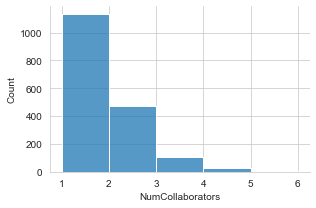

In [146]:
G4 = GraphWrapper(df[(df.Week > pd.Timestamp(2015,12,31))])

display_graph_properties(G4)

In [185]:
G_1519, artist2ind, ind2artist = make_graph(df[(df.Week > pd.Timestamp(2015,12,31))], display_info=True)

* \# unique songs: 1,749
* \# unique artists: 650

* 650 nodes, 911 edges

* \# of connected components: **233**

In [188]:
G_1519_cliques = list(nx.enumerate_all_cliques(G_1519))

In [190]:
len(G_1519_cliques)

2743

In [187]:
np.argsort(list(map(len, G_1519_cliques)))[::-1][:10]

array([2742, 2732, 2741, 2725, 2726, 2728, 2729, 2730, 2731, 2727])

In [192]:
G_1519_cliques = list(nx.enumerate_all_cliques(G_1519))
biggest_cliques = np.argsort(list(map(len, G_1519_cliques)))[::-1][:10]
for c in biggest_cliques:
    print(list(map(lambda x: ind2artist[x], G_1519_cliques[c])))

['Travis Scott', 'Offset', '21 Savage', 'Metro Boomin', 'Future', 'Young Thug', 'Drake']
['Travis Scott', '21 Savage', 'Metro Boomin', 'Future', 'Young Thug', 'Drake']
['J. Cole', 'Dreamville', 'JID', 'Bas', 'EARTHGANG', 'Young Nudy']
['Travis Scott', 'Offset', 'Quavo', '21 Savage', 'Metro Boomin', 'Drake']
['Travis Scott', 'Offset', '21 Savage', 'Metro Boomin', 'Future', 'Young Thug']
['Travis Scott', 'Offset', '21 Savage', 'Metro Boomin', 'Future', 'Drake']
['Travis Scott', 'Offset', '21 Savage', 'Metro Boomin', 'Young Thug', 'Drake']
['Travis Scott', 'Offset', '21 Savage', 'Future', 'Young Thug', 'Drake']
['Travis Scott', 'Offset', 'Metro Boomin', 'Future', 'Young Thug', 'Drake']
['Travis Scott', 'Offset', '21 Savage', 'Metro Boomin', 'Future', 'Kodak Black']


In [193]:
cc1519 = list(map(len, nx.connected_components(G_1519)))
cc_counts = pd.Series(cc1519).value_counts().rename('Count').to_frame()
cc_counts.index = cc_counts.index.rename('Connected Component Size')
display(cc_counts)

,Count
Connected Component Size,
1,195
2,25
3,8
4,3
5,1
364,1


In [194]:
G = G_1519

Keep connected components with 5 or more artsits only.

In [195]:
for component in list(nx.connected_components(G)):
    if len(component) < 2:
        for node in component:
            G.remove_node(node)

display(Markdown(
    "* Number of connected components with 5 or more nodes: **{}**".format(
        len(list(nx.connected_components(G))))))

* Number of connected components with 5 or more nodes: **38**

Network plotting code is based on https://plot.ly/python/network-graphs/.